<a href="https://colab.research.google.com/github/ivander11/resnet18-cifar10-pruning/blob/main/Neural_Network_Pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Pruning: ResNet-18 on CIFAR-10

**Based on: https://medium.com/@arikpoznanski/neural-network-pruning-how-to-accelerate-inference-with-minimal-accuracy-loss-936cad741c2a**

##Setup

In [ ]:
!pip install torch-pruning

In [ ]:
import os
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch_pruning as tp
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


##Data Loading

In [ ]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2430, 0.2610)

transform_train = transforms.Compose([  # Train with augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_loader = DataLoader(
    datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train),
    batch_size=128, shuffle=True
)

test_loader = DataLoader(
    datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test),
    batch_size=256
)

##Adjust ResNet18 network for CIFAR-10 dataset

---



In [ ]:
def get_resnet18_for_cifar10():
    model = models.resnet18(weights=None, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    return model.to(device)

full_model = get_resnet18_for_cifar10()

## Define Train and Evaluate functions

In [ ]:
def train(model, loader, epochs, lr=0.1, save_path="model.pth", silent=False, plot_losses=True):
    if os.path.exists(save_path):
        if not silent:
            print(f"Model already trained. Loading from {save_path}")
        model.load_state_dict(torch.load(save_path, map_location=device))
        return [], []

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    model.train()
    train_losses, train_accs = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

        avg_loss = running_loss / len(loader)
        avg_acc = correct / total
        train_losses.append(avg_loss)
        train_accs.append(avg_acc)

        scheduler.step()

        if not silent:
            print(f"Epoch {epoch+1}: loss={avg_loss:.4f}, acc={avg_acc*100:.2f}%")

    torch.save(model.state_dict(), save_path)
    if not silent:
        print(f"Training complete. Model saved to {save_path}")

    if plot_losses:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.plot(train_losses); ax1.set_title('Train Loss'); ax1.set_xlabel('Epoch')
        ax2.plot(train_accs); ax2.set_title('Train Acc (%)'); ax2.set_xlabel('Epoch')
        plt.tight_layout()
        plt.show()

    return train_losses, train_accs

In [ ]:
def evaluate(model):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

##Define helper functions to measure latency

In [ ]:
class Timer:
    def __init__(self):
        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.starter = torch.cuda.Event(enable_timing=True)
            self.ender = torch.cuda.Event(enable_timing=True)

    def start(self):
        if self.use_cuda:
            self.starter.record()
        else:
            self.start_time = time.time()

    def stop(self):
        if self.use_cuda:
            self.ender.record()
            torch.cuda.synchronize()
            return self.starter.elapsed_time(self.ender)
        else:
            return (time.time() - self.start_time) * 1000

In [ ]:
def estimate_latency(model, example_inputs, repetitions=50, batch_size=128):
    if isinstance(example_inputs, int):
        example_inputs = torch.rand(batch_size, 3, 32, 32).to(device)

    timer = Timer()
    timings = np.zeros((repetitions, 1))
    for _ in range(5):
        _ = model(example_inputs)
    with torch.no_grad():
        for rep in range(repetitions):
            timer.start()
            _ = model(example_inputs)
            elapsed = timer.stop()
            timings[rep] = elapsed
    return np.mean(timings), np.std(timings)

##Train and Evaluate full model

In [ ]:
train_losses, train_accs = train(full_model, train_loader, epochs=10, save_path="full_model.pth")
accuracy_full = evaluate(full_model)
print(f"Full model test acc: {accuracy_full*100:.2f}%")

example_input = torch.rand(128, 3, 32, 32).to(device)
example_input_single = torch.rand(1, 3, 32, 32).to(device)
macs, parameters = tp.utils.count_ops_and_params(full_model, example_input)
latency_mu, latency_std = estimate_latency(full_model, example_input)
latency_single_mu, _ = estimate_latency(full_model, example_input_single)

print(f"[full model] MACs: {macs/1e9:.2f} G, Params: {parameters/1e6:.2f} M, Latency (batch=128): {latency_mu:.2f} ± {latency_std:.2f} ms, (batch=1): {latency_single_mu:.2f} ms, Acc: {accuracy_full*100:.2f}%")

Model already trained. Loading from full_model.pth
Full model test acc: 89.14%
[full model] MACs: 0.56 G, Params: 11.17 M, Latency (batch=128): 27.24 ± 0.56 ms, (batch=1): 2.65 ms, Acc: 89.14%


##Visualize Filters (Before Pruning)

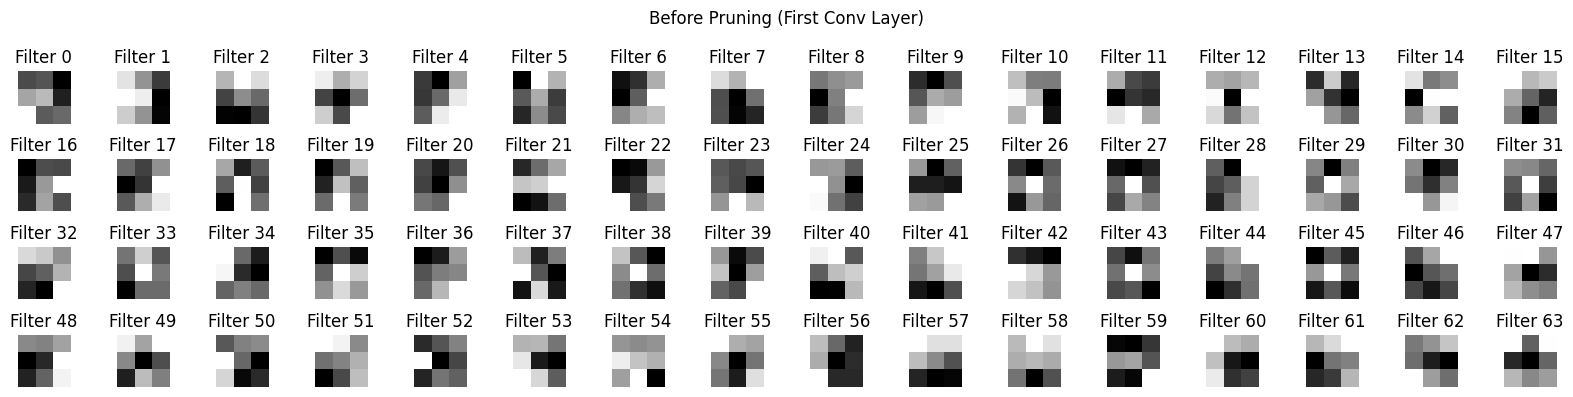

In [ ]:
# Plot first conv filters
def plot_filters(model, title="Filters"):
    w = model.conv1.weight.data.cpu()  # Shape: (64, 3, 3, 3)
    fig, axs = plt.subplots(4, 16, figsize=(16, 4))
    for i in range(64):
        ax = axs[i//16, i%16]
        # Average over channels for grayscale
        filt = w[i].mean(0).squeeze().numpy()
        im = ax.imshow(filt, cmap='gray')
        ax.set_title(f'Filter {i}')
        ax.axis('off')
    plt.suptitle(f"{title} (First Conv Layer)")
    plt.tight_layout()
    plt.show()

plot_filters(full_model, "Before Pruning")

## Pruning Setup

In [ ]:
pruned_model = copy.deepcopy(full_model)
pruned_model = pruned_model.to(device)

ignored_layers = [m for m in pruned_model.modules() if isinstance(m, nn.Linear) and m.out_features == 10]

iterative_steps = 20
pruning_ratio_target = 0.9
pruner = tp.pruner.MagnitudePruner(
    model=pruned_model,
    example_inputs=example_input,
    importance=tp.importance.MagnitudeImportance(p=2),
    pruning_ratio=pruning_ratio_target,
    iterative_steps=iterative_steps,
    ignored_layers=ignored_layers,
    round_to=2,
)

# Lists for plotting
pruning_ratios, acc_before_list, acc_after_list = [], [], []
macs_list, params_list, latency_list = [], [], []

##Iterative Pruning Loop

In [ ]:
for iter in range(iterative_steps):
    pruner.step()
    acc_before = evaluate(pruned_model)
    train(pruned_model, train_loader, epochs=1, save_path=f"pruned_model_{iter}.pth", silent=True, plot_losses=False)  # No plot per step
    acc_after = evaluate(pruned_model)

    current_pruning_ratio = pruning_ratio_target / iterative_steps * (iter + 1)

    macs1, params1 = tp.utils.count_ops_and_params(pruned_model, example_input)
    latency_mu1, _ = estimate_latency(pruned_model, example_input)

    # Collect
    pruning_ratios.append(current_pruning_ratio)
    acc_before_list.append(acc_before)
    acc_after_list.append(acc_after)
    macs_list.append(macs1 / 1e9)
    params_list.append(params1 / 1e6)
    latency_list.append(latency_mu1)

    print(f"Step {iter+1}: Prune {current_pruning_ratio:.2f}, Acc: {acc_before*100:.2f}% → {acc_after*100:.2f}%, MACs: {macs1/1e9:.2f}G, Params: {params1/1e6:.2f}M, Latency: {latency_mu1:.2f}ms")

Step 1: Prune 0.04, Acc: 87.50% → 76.65%, MACs: 0.50G, Params: 10.15M, Latency: 26.51ms
Step 2: Prune 0.09, Acc: 74.17% → 75.74%, MACs: 0.46G, Params: 9.18M, Latency: 25.32ms
Step 3: Prune 0.14, Acc: 73.44% → 81.29%, MACs: 0.41G, Params: 8.30M, Latency: 24.31ms
Step 4: Prune 0.18, Acc: 81.20% → 69.32%, MACs: 0.37G, Params: 7.43M, Latency: 22.98ms
Step 5: Prune 0.22, Acc: 66.98% → 78.86%, MACs: 0.33G, Params: 6.67M, Latency: 21.65ms
Step 6: Prune 0.27, Acc: 74.91% → 82.91%, MACs: 0.29G, Params: 5.89M, Latency: 19.90ms
Step 7: Prune 0.32, Acc: 79.42% → 80.16%, MACs: 0.25G, Params: 5.19M, Latency: 18.71ms
Step 8: Prune 0.36, Acc: 76.58% → 79.33%, MACs: 0.22G, Params: 4.51M, Latency: 16.93ms
Step 9: Prune 0.40, Acc: 72.79% → 66.30%, MACs: 0.20G, Params: 3.94M, Latency: 15.81ms
Step 10: Prune 0.45, Acc: 61.43% → 80.39%, MACs: 0.16G, Params: 3.34M, Latency: 14.63ms
Step 11: Prune 0.49, Acc: 73.45% → 82.57%, MACs: 0.14G, Params: 2.83M, Latency: 10.47ms
Step 12: Prune 0.54, Acc: 67.40% → 72.89

## Extra fine-tune last pruned model

In [ ]:
# Extra fine-tune
train(pruned_model, train_loader, epochs=10, save_path="pruned_model_final.pth", silent=False, plot_losses=True)  # Plot final curves
accuracy_final = evaluate(pruned_model)
print(f"Final pruned acc: {accuracy_final*100:.2f}%")

Model already trained. Loading from pruned_model_final.pth
Final pruned acc: 84.39%


## Plot Visualization

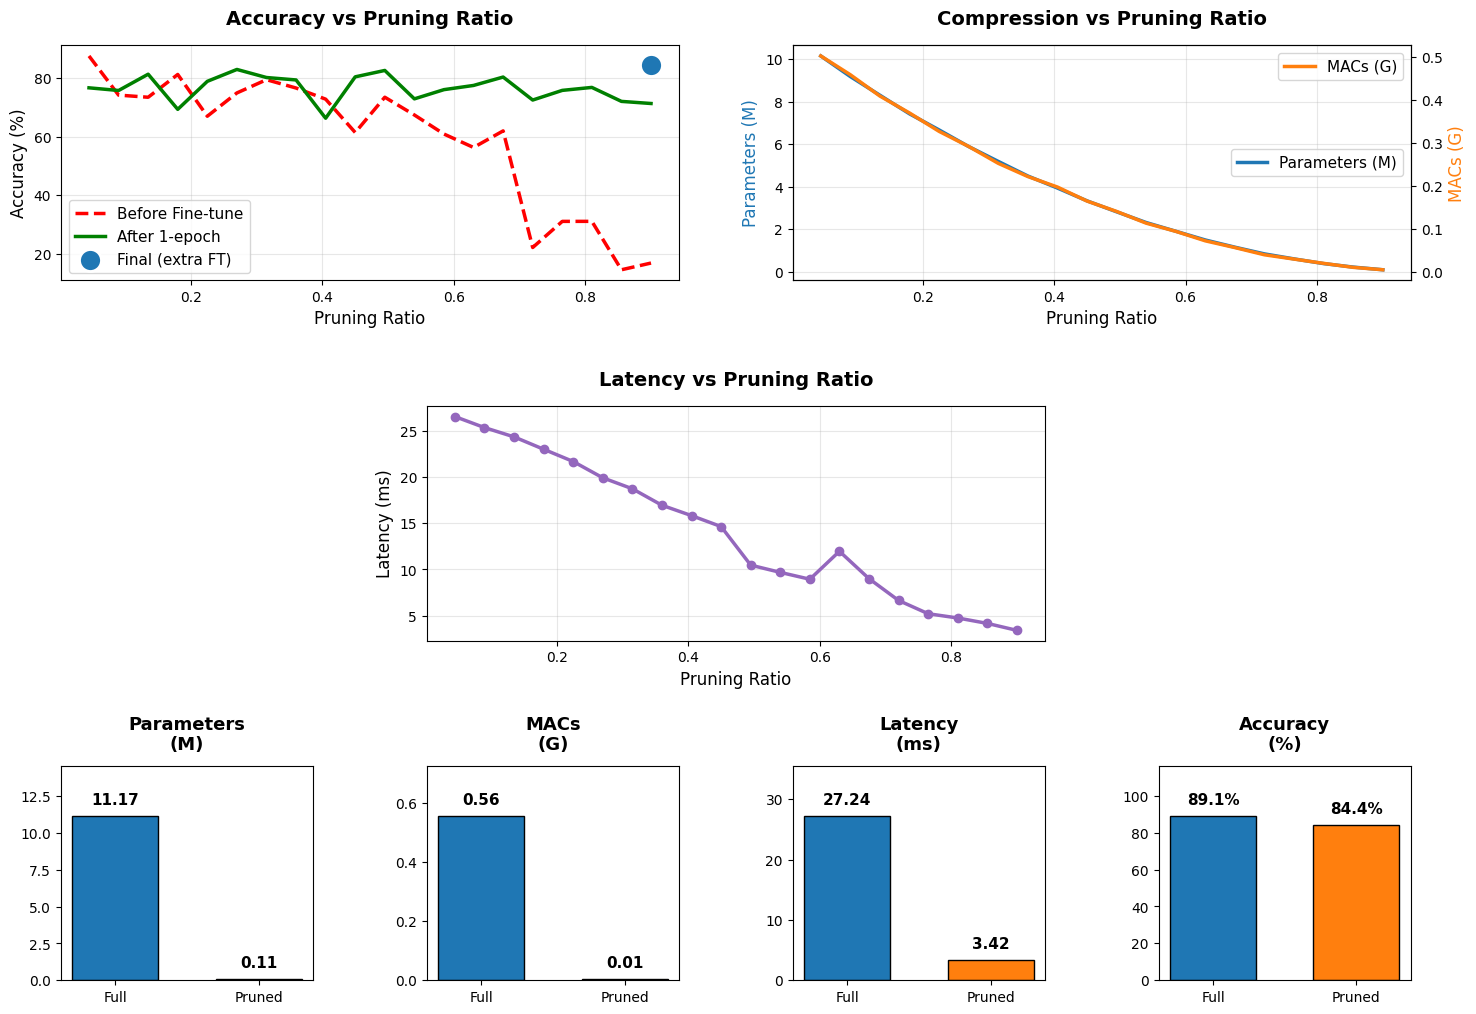

In [ ]:
import matplotlib.pyplot as plt

full_vals = [parameters/1e6, macs/1e9, latency_mu, accuracy_full*100]  # [Params(M), MACs(G), Latency(ms), Accuracy(%)]

pruned_vals = [params_list[-1], macs_list[-1], latency_list[-1], accuracy_final*100]

fig = plt.figure(figsize=(15, 11))
gs = fig.add_gridspec(3, 4, height_ratios=[1.1, 1.1, 1], hspace=0.55, wspace=0.45)

# Top row: three curves
ax1 = fig.add_subplot(gs[0, :2])   # Accuracy
ax2 = fig.add_subplot(gs[0, 2:])   # Compression
ax3 = fig.add_subplot(gs[1, 1:3])  # Latency

# Accuracy Curve
ax1.plot(pruning_ratios, [a*100 for a in acc_before_list], 'r--', lw=2.5, label='Before Fine-tune')
ax1.plot(pruning_ratios, [a*100 for a in acc_after_list], 'g-', lw=2.5, label='After 1-epoch')
ax1.scatter(pruning_ratios[-1], 84.39, c='#1f77b4', s=250, zorder=10,
            edgecolors='white', linewidth=2, label='Final (extra FT)')
ax1.set_xlabel('Pruning Ratio', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy vs Pruning Ratio', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Compression Curve
ax2.plot(pruning_ratios, params_list, '#1f77b4', lw=2.5, label='Parameters (M)')
ax2b = ax2.twinx()
ax2b.plot(pruning_ratios, macs_list, '#ff7f0e', lw=2.5, label='MACs (G)')
ax2.set_xlabel('Pruning Ratio', fontsize=12)
ax2.set_ylabel('Parameters (M)', color='#1f77b4', fontsize=12)
ax2b.set_ylabel('MACs (G)', color='#ff7f0e', fontsize=12)
ax2.set_title('Compression vs Pruning Ratio', fontsize=14, fontweight='bold', pad=15)
ax2.legend(loc='center right', fontsize=11)
ax2b.legend(loc='upper right', fontsize=11)
ax2.grid(True, alpha=0.3)

# Latency Curve
ax3.plot(pruning_ratios, latency_list, '#9467bd', lw=2.5, marker='o', markersize=6)
ax3.set_xlabel('Pruning Ratio', fontsize=12)
ax3.set_ylabel('Latency (ms)', fontsize=12)
ax3.set_title('Latency vs Pruning Ratio', fontsize=14, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3)

# Bottom row
metrics = ['Parameters\n(M)', 'MACs\n(G)', 'Latency\n(ms)', 'Accuracy\n(%)']

for i, (title, f, p) in enumerate(zip(metrics, full_vals, pruned_vals)):
    ax = fig.add_subplot(gs[2, i])
    bars = ax.bar(['Full', 'Pruned'], [f, p], color=['#1f77b4', '#ff7f0e'], width=0.6, edgecolor='black')

    ax.set_title(title, fontsize=13, fontweight='bold', pad=12)

    local_max = max(f, p)
    ax.set_ylim(0, local_max * 1.3)

    for bar in bars:
        h = bar.get_height()
        txt = f'{h:.1f}%' if i == 3 else f'{h:.2f}'

        offset = local_max * 0.05
        ax.text(bar.get_x() + bar.get_width()/2., h + offset,
                txt, ha='center', va='bottom', fontsize=11, fontweight='bold')


plt.subplots_adjust(top=0.93, bottom=0.08, left=0.06, right=0.96)
plt.show()